In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import requests
import json
from pathlib import Path
from IPython.display import clear_output

In [2]:
def get_game(game_year, game_type, game_number):
    """Récupère les infos d'une partie à partir de la chache ou de l'API

    Paramètres:
    game_year (int): Année ou la partie a eu lieu
    game_type (int): Type de la partie (1 = pré-saison, 2 = saison régulière, 3 = playoffs, 4 = all-star)
    game_numer (int): Numéro de la partie

    Retourne:
    data (dict): Données de la partie spécifiée
    """

    # Conversion des int en string pour l'API
    str_year = str(game_year)
    str_type = str(game_type).zfill(2) 
    str_num = str(game_number).zfill(4) 

    # Création de la requête GET
    game_ID = str_year + str_type + str_num 
    url = f"https://api-web.nhle.com/v1/gamecenter/{game_ID}/play-by-play"  

    # Création du path du fichier qui va stocker les données
    file_name = game_ID + ".json" 
    base_path = Path("data") / str_year 
    base_path.mkdir(parents=True, exist_ok=True) 
    complete_path = base_path / file_name 

    # Si les données sont présentes localement on les récupère directement
    if complete_path.is_file():
        with open(complete_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    # Sinon on fait une requête à l'API de la NHL
    else:   
        response = requests.get(url) 
        if response.status_code == 200: 
            data = response.json()     
            with open(complete_path, 'w', encoding='utf-8') as f: 
               json.dump(data, f, indent=4) 
            return data
        else: 
            print(f"Erreur {response.status_code} lors du téléchargement.") 
            return None  

In [3]:
def fetch_full_year_regular(year):
    """Récupère les données des parties d'une saison régulière complète

    Paramètre:
    year (int): Année de la saison régulière
    """
    for i in range(1, 1351): 
        data = get_game(year, 2, i) 
        if data is None:
            print(f"Arrêt à la partie {i}, fin de la saison détectée.")
            break

In [4]:
fetch_full_year_regular(2023)

Erreur 404 lors du téléchargement.
Arrêt à la partie 1313, fin de la saison détectée.


In [5]:
def play_context(data):
    """Récupère plusieurs données pour notre outil de déboggage interactif

    Paramètre:
    data: Toutes les données d'une partie

    Retourne:
    home, away, team_by_id, player_name: L'équipe à domicile, l'équipe visiteuse, les noms des deux équipes et le noms des joueurs
    """
    
    home = data["homeTeam"]
    away = data["awayTeam"]
    team_by_id = {home["id"]: home, away["id"]: away}
    player_name = {}
    
    for player in data.get("rosterSpots", []):
        player_id = player.get("playerId")
        first_name = (player.get("firstName") or {}).get("default", "")
        last_name = (player.get("lastName") or {}).get("default", "")
        if player_id is not None:
            player_name[player_id] = (first_name + " " + last_name).strip()

    return home, away, team_by_id, player_name

In [6]:
def get_player_name(player_id):
    """Récupère le nom d'un joueur s'il est connu

    Parmètre:
    player_id (int): ID du joueur

    Retourne:
    player_name (String): Nom du joueur
    
    """
    return player_name.get(player_id, f"#{player_id}" if player_id is not None else "Unknown")
    
def play_description(play, team_by_id, player_name):
    """Retourne les données du jeu selon le type de ce dernier

    Paramètres:
    play (dict): Données complètes du jeu
    team_by_id: Équipes du jeu
    player_name: Joueurs du jeu
    
    """
    type_ofplay = play.get("typeDescKey", "")
    details = play.get("details", {}) or {}

    match type_ofplay:
        case "blocked-shot":
            blocker = get_player_name(details.get('blockingPlayerId'))
            shooter = get_player_name(details.get('shootingPlayerId'))
            return f"{blocker} blocked shot from {shooter}"

        case "shot-on-goal":
            shot_type = details.get("shotType")
            suffix = f" ({shot_type})" if shot_type else ""
            return f"{get_player_name(details.get('shootingPlayerId'))} shot on goal{suffix}"

        case "missed-shot":
            shot_type = details.get("shotType")
            suffix = f" ({shot_type})" if shot_type else ""
            return f"{get_player_name(details.get('shootingPlayerId'))} missed shot{suffix}"

        case "goal":
            scorer = get_player_name(details.get('scoringPlayerId'))
            return f"GOAL — {scorer}"

        case "faceoff":
            winner = get_player_name(details.get('winningPlayerId'))
            return f"Faceoff won by {winner}"

        case "hit":
            hitter = get_player_name(details.get('hittingPlayerId'))
            hittee = get_player_name(details.get('hitteePlayerId'))
            return f"{hitter} hit {hittee}"

        case _:
            return type_ofplay or "event"

In [7]:
def draw_play(index=0):
    """Affiche les informations d'un jeu ainsi qu'un diagramme avec l'endroit du jeu 
    Méthode utilisée pour le slider play_ui

    Paramètre:
    index (int): valeur initiale pour le IntSlider
    """
    clear_output(wait=True)
    
    # Création de variables pour l'affichage
    current_play = all_plays[index]
    details = current_play.get('details', {}) or {}
    x = details.get('xCoord')
    y = details.get('yCoord')
    start_utc = data.get("startTimeUTC", "")
    game_id = data.get("id", "")
    last_type = (data.get("gameOutcome") or {}).get("lastPeriodType", "")
    last_type = {"REG": "", "OT": "OT", "SO": "SO"}.get(last_type, last_type)
    period = (current_play.get("periodDescriptor") or {}).get("number", "?")
    time_in_period = current_play.get("timeInPeriod", "??:??")
    desc = play_description(current_play, team_by_id, player_name)

    # Affichage des informations du jeu
    print(start_utc)
    print(f"Game ID: {game_id}; {home['abbrev']} (home) vs {away['abbrev']} (away)")
    if last_type:
        print(last_type)
    print("")
    print(f"{'':12}{'Home':>6}{'Away':>6}")
    print(f"{'Teams:':12}{home['abbrev']:>6}{away['abbrev']:>6}")
    print(f"{'Goals:':12}{home.get('score','?'):>6}{away.get('score','?'):>6}")
    print(f"{'SoG:':12}{home.get('sog','?'):>6}{away.get('sog','?'):>6}")
    print(f"{'SO Goals:':12}{'None':>6}{'None':>6}")
    print(f"{'SO Attempts:':12}{'None':>6}{'None':>6}")
    print("")

    # Dessin du diagramme du jeu
    img = np.asarray(Image.open('figures/nhl_rink.png').convert('RGB'))
    my_extent = [-100, 100, -42.5, 42.5] 
    plt.imshow(img, extent=my_extent)
    plt.text(-60, 45, away["abbrev"], ha="center", va="bottom")
    plt.text(60, 45, home["abbrev"], ha="center", va="bottom")
    if x is not None and y is not None:
        plt.scatter(x, y, s=100, c='blue', marker='o')   
    plt.title(f"{desc}\n{time_in_period} P-{period}")  
    plt.show()

In [8]:
def on_game_change(change):
    """ Méthode utilisée pour le slider game_slider
    """
    global data, all_plays, home, away, team_by_id, player_name
    new_game = change["new"]
    data = get_game(year, game_type, new_game)
    all_plays = data.get("plays", []) or []
    home, away, team_by_id, player_name = play_context(data)
    idx_slider.max = max(0, len(all_plays) - 1)

    # Si le slider est à 0, on force le rafraichissement de play_ui
    if idx_slider.value == 0:
        output_widget = play_ui.children[-1]
        output_widget.clear_output(wait=True)
        with output_widget:
            draw_play(0)  
    # Sinon on le met à 0 (rafraichit par lui-même)
    else:
        idx_slider.value = 0

In [9]:
global all_plays, data, home, away, team_by_id, player_name

year = 2023
game_type = 2
data = get_game(year, game_type, 1)
all_plays = data["plays"]
home, away, team_by_id, player_name = play_context(data)

game_slider = widgets.IntSlider(
    value=1, min=1, max=1312, step=1, description="Game",
    continuous_update=False
)
play_ui = widgets.interactive(draw_play, index=(0, len(all_plays)-1, 1)) 
idx_slider = play_ui.children[0]  
game_slider.observe(on_game_change, names="value")

display(widgets.VBox([game_slider, play_ui]))

In [13]:
def get_goal_strength(play):
    if play.get('typeDescKey') != 'goal':
        return ''
    
    # On récupère le code de situation (ex: "1541")
    situation_code = play.get('situationCode')

    # On parse les chiffres (Attention: l'ordre est Away Goalie, Away Skaters, Home Skaters, Home Goalie)
    # Source: Communauté API NHL (les indices sont 0, 1, 2, 3)
    away_skaters = int(situation_code[1])
    home_skaters = int(situation_code[2])
    
    # On identifie l'équipe qui a marqué
    details = play.get('details', {})
    scoring_team_id = details.get('eventOwnerTeamId')
    
    # On détermine le nombre de patineurs pour l'équipe qui marque vs l'adversaire
    # Note: On utilise les variables globales 'home' et 'away' du contexte
    if scoring_team_id == away.get('id'):
        goals_for = away_skaters
        goals_against = home_skaters
    elif scoring_team_id == home.get('id'):
        goals_for = home_skaters
        goals_against = away_skaters
    else:
        return "Unknown"

    # --- LOGIQUE DE DÉTECTION ---
    
    # 1. Avantage numérique (Power Play)
    # Si j'ai plus de joueurs que l'autre ET que l'autre en a moins de 5 (pour exclure le 6v5 filet désert)
    if (goals_for > goals_against) and (goals_against < 5):
        return "PP"
        
    # 2. Désavantage numérique (Shorthanded)
    # Si j'ai moins de joueurs que l'autre ET que j'en ai moins de 5 (pour exclure le 5v6 filet désert)
    elif (goals_for < goals_against) and (goals_for < 5):
        return "SH"
        
    # 3. Force égale (Even Strength)
    # Inclut le 5v5, 4v4, 3v3 et les buts en filet désert classiques (5v6 ou 6v5 sans pénalité)
    else:
        return "EV"

def create_plays_dataframe(plays):
    types = ['goal', 'shot-on-goal']
    filtered_plays = [p for p in plays if p.get('typeDescKey') in types]


    clean_data = []
    for play in filtered_plays:
        details = play.get('details', {})
        owner_id = details.get('eventOwnerTeamId')
        
        if owner_id == away.get('id'):
            teamShot = away.get('abbrev')
        elif owner_id == home.get('id'):
            teamShot = home.get('abbrev')
        
        shooter_id = details.get('shootingPlayerId') or details.get('scoringPlayerId')
        goalie_id = details.get('goalieInNetId')
        is_empty_net = (play.get('typeDescKey') == 'goal') and (goalie_id is None)
        
        clean_data.append({
            'timeInPeriod': play.get('timeInPeriod'),
            'period': (play.get('periodDescriptor') or {}).get('number', '?'),
            'eventId': play.get('eventId'),
            'teamShot': teamShot,
            'typeEvent': play.get('typeDescKey'),
            'x': details.get('xCoord'), 
            'y': details.get('yCoord'),
            'shooter': get_player_name(shooter_id),
            'goalie': get_player_name(goalie_id),
            'typeShot' : details.get('shotType'),
            'openNet' : is_empty_net,
            'goalStrenght' : get_goal_strength(play)
        })
    
    new_df = pd.DataFrame(clean_data)
    return new_df

play_df = create_plays_dataframe(all_plays)
play_df

,timeInPeriod,period,eventId,teamShot,typeEvent,x,y,shooter,goalie,typeShot,openNet,goalStrenght
0,01:01,1,63,TBL,shot-on-goal,58,-25,Darren Raddysh,Juuse Saros,wrist,False,
1,01:10,1,151,TBL,shot-on-goal,81,8,Brayden Point,Juuse Saros,tip-in,False,
2,01:47,1,70,TBL,shot-on-goal,55,30,Tanner Jeannot,Juuse Saros,snap,False,
3,02:57,1,152,TBL,shot-on-goal,58,-30,Michael Eyssimont,Juuse Saros,wrist,False,
4,07:15,1,239,NSH,shot-on-goal,-75,-14,Yakov Trenin,Jonas Johansson,snap,False,
...,...,...,...,...,...,...,...,...,...,...,...,...
60,18:11,3,1179,NSH,shot-on-goal,-82,-19,Filip Forsberg,Jonas Johansson,wrist,False,
61,18:12,3,1180,NSH,shot-on-goal,-85,-7,Juuso Parssinen,Jonas Johansson,poke,False,
62,18:25,3,1184,NSH,shot-on-goal,-39,20,Roman Josi,Jonas Johansson,slap,False,
63,19:48,3,1195,NSH,shot-on-goal,-40,-28,Tommy Novak,Jonas Johansson,slap,False,


In [14]:
def load_full_regular_season_dataframe(year, game_type=2, max_games=1312):
    global data, all_plays, home, away, team_by_id, player_name

    all_game_dfs = []

    for game_number in range(1, max_games + 1):
            data = get_game(year, game_type, game_number)
            if not data or "plays" not in data:
                continue

            all_plays = data["plays"]
            home, away, team_by_id, player_name = play_context(data)

            df_game = create_plays_dataframe(all_plays)

            # Ajoute des colonnes utiles pour filtrer ensuite
            game_id = data.get("id")
            df_game["gameId"] = game_id
            df_game["season"] = int(str(game_id)[:4]) if game_id else None

            all_game_dfs.append(df_game)

    return pd.concat(all_game_dfs, ignore_index=True)

year = 2023
play_df = load_full_regular_season_dataframe(year, game_type=2, max_games=1312)

play_df.shape, play_df["teamShot"].nunique()
play_df

,timeInPeriod,period,eventId,teamShot,typeEvent,x,y,shooter,goalie,typeShot,openNet,goalStrenght,gameId,season
0,01:01,1,63,TBL,shot-on-goal,58,-25,Darren Raddysh,Juuse Saros,wrist,False,,2023020001,2023
1,01:10,1,151,TBL,shot-on-goal,81,8,Brayden Point,Juuse Saros,tip-in,False,,2023020001,2023
2,01:47,1,70,TBL,shot-on-goal,55,30,Tanner Jeannot,Juuse Saros,snap,False,,2023020001,2023
3,02:57,1,152,TBL,shot-on-goal,58,-30,Michael Eyssimont,Juuse Saros,wrist,False,,2023020001,2023
4,07:15,1,239,NSH,shot-on-goal,-75,-14,Yakov Trenin,Jonas Johansson,snap,False,,2023020001,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79978,09:00,3,935,LAK,shot-on-goal,-73,-27,Phillip Danault,Arvid Soderblom,wrist,False,,2023021312,2023
79979,12:41,3,971,LAK,shot-on-goal,-73,-21,Quinton Byfield,Arvid Soderblom,wrist,False,,2023021312,2023
79980,17:28,3,1024,LAK,shot-on-goal,-27,-26,Vladislav Gavrikov,Arvid Soderblom,slap,False,,2023021312,2023
79981,18:39,3,1039,LAK,goal,-74,7,Viktor Arvidsson,Arvid Soderblom,wrist,False,PP,2023021312,2023


In [15]:
# pour l'instant la visualisation simple va marcher que pour la saison qu'on a chargé mais je vais changer après pour charger toutes les saisons

import seaborn as sns
sns.set(style="ticks")

In [16]:
def summarize_shots_and_goals_by_shot_type(season_dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Trie le dataframe par type de tir
    Paramètre : Dataframe d'une saison
    
    Sortie: Data frame trié
    """
    shots_and_goals = season_dataframe[
        season_dataframe["typeEvent"].isin(["shot-on-goal", "goal"])
    ].copy()

    shots_and_goals["typeShot"] = shots_and_goals["typeShot"].fillna("Unknown")
    shots_and_goals["isGoal"] = (shots_and_goals["typeEvent"] == "goal").astype(int)

    summary_by_shot_type = (
        shots_and_goals.groupby("typeShot", as_index=False)
        .agg(shots=("typeEvent", "size"), goals=("isGoal", "sum"),)
    )

    summary_by_shot_type["goal_rate"] = summary_by_shot_type["goals"] / summary_by_shot_type["shots"]
    return summary_by_shot_type.sort_values("shots", ascending=False)


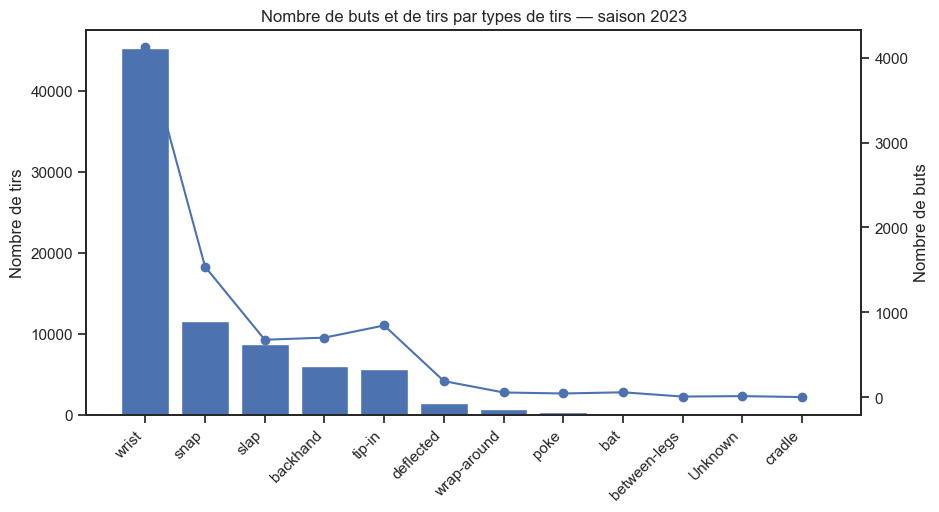

In [18]:

shot_type_summary = summarize_shots_and_goals_by_shot_type(play_df)

figure, primary_axis = plt.subplots(figsize=(10, 5))
bar_positions = np.arange(len(shot_type_summary))

# Barres = nombre total de tirs (incluant les goals)
primary_axis.bar(bar_positions, shot_type_summary["shots"])
primary_axis.set_xticks(bar_positions)
primary_axis.set_xticklabels(shot_type_summary["typeShot"], rotation=45, ha="right")
primary_axis.set_ylabel("Nombre de tirs")
primary_axis.set_title(
    f"Nombre de buts et de tirs par types de tirs — saison {year}"
)

# Ligne = nombre de buts (axe secondaire)
secondary_axis = primary_axis.twinx()
secondary_axis.plot(bar_positions, shot_type_summary["goals"], marker="o")
secondary_axis.set_ylabel("Nombre de buts")

plt.show()

In [19]:
def compute_shot_distance(x_coord, y_coord, goal_x=89.0, goal_y=0.0):
    """Distance euclidienne entre le tir et le filet. On prend abs(x) pour standardiser la patinoire."""
    distance = np.sqrt((goal_x - abs(float(x_coord)))**2 + (float(y_coord) - goal_y)**2)
    return distance

def compute_distance_from_row(row):
    return compute_shot_distance(row["x"], row["y"])

shots_and_goals = play_df[play_df["typeEvent"].isin(["shot-on-goal", "goal"])].copy()
shots_and_goals["isGoal"] = (shots_and_goals["typeEvent"] == "goal").astype(int)
shots_and_goals["distance"] = shots_and_goals.apply(compute_distance_from_row, axis=1)

def bin_midpoint(interval):
    return (interval.left + interval.right) / 2


C:\Users\Pierre Emery\AppData\Local\Temp\ipykernel_12016\3957737.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shots_and_goals.groupby("distance_bin", as_index=False)


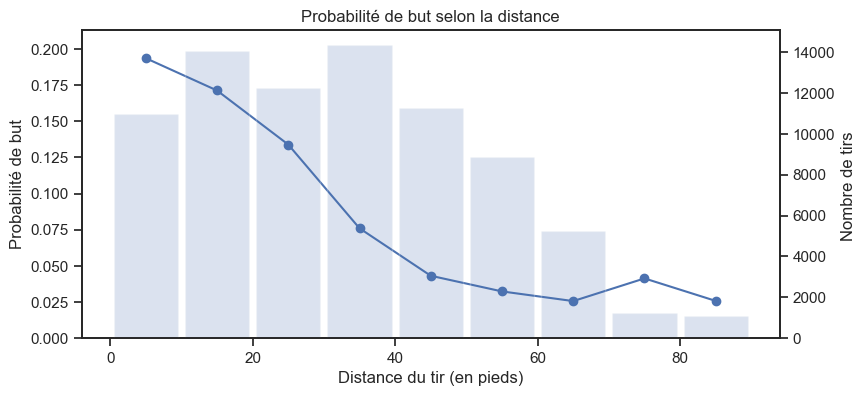

In [20]:
bin_size = 10  # par tranche de 10 pieds
distance_bins = np.arange(0, max(shots_and_goals['distance'])+1, bin_size) 

shots_and_goals["distance_bin"] = pd.cut(shots_and_goals["distance"], bins=distance_bins, right=False)

distance_summary = (
    shots_and_goals.groupby("distance_bin", as_index=False)
    .agg(
        goal_probability=("isGoal", "mean"),
        number_of_shots=("isGoal", "size")
    )
)

distance_summary["distance_mid"] = distance_summary["distance_bin"].apply(bin_midpoint)

fig, ax1 = plt.subplots(figsize=(9, 4))

# Courbe: probabilité de but
ax1.plot(distance_summary["distance_mid"], distance_summary["goal_probability"], marker="o")
ax1.set_xlabel("Distance du tir (en pieds)")
ax1.set_ylabel("Probabilité de but")
ax1.set_title("Probabilité de but selon la distance")
ax1.set_ylim(0, max(distance_summary["goal_probability"].max() * 1.1, 0.05))

# Barres en fond: nombre de tirs par bin (pour montrer où il y a beaucoup de données)
ax2 = ax1.twinx()
ax2.bar(distance_summary["distance_mid"], distance_summary["number_of_shots"], alpha=0.2, width=bin_size*0.9)
ax2.set_ylabel("Nombre de tirs ")

plt.show()

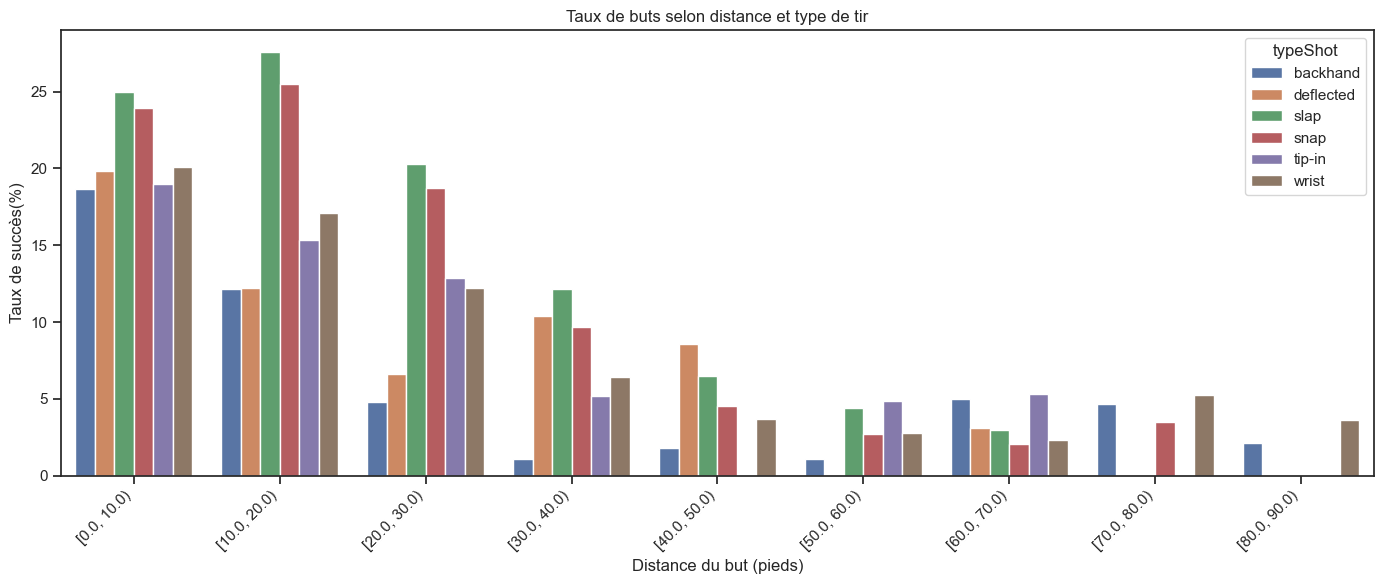

In [23]:
goal_rate_table = (
    shots_and_goals
    .groupby(["distance_bin", "typeShot"], observed=True, as_index=False)
    .agg(goal_rate=("isGoal", "mean"), shots=("isGoal", "size"),)
)

top_types = shots_and_goals["typeShot"].value_counts().head(6).index
filtered_table = goal_rate_table[goal_rate_table["typeShot"].isin(top_types)].copy()

# Labels distance
filtered_table["distance_label"] = filtered_table["distance_bin"].astype(str)

# en pourcentage
filtered_table["goal_pct"] = 100 * filtered_table["goal_rate"]

plt.figure(figsize=(14,6))
sns.barplot(data=filtered_table, x="distance_label", y="goal_pct", hue="typeShot")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Distance du but (pieds)")
plt.ylabel("Taux de succès(%)")
plt.title("Taux de buts selon distance et type de tir")
plt.tight_layout()
plt.show()